In [2]:
TODAY="2021-11-13"
TASK = "phylogenetic-determination"
DIR = "$(homedir())/$(TODAY)-$(TASK)"
if !isdir(DIR)
    mkdir(DIR)
end
cd(DIR)

In [3]:
import Pkg

pkgs = [
"JSON",
"HTTP",
"Dates",
"uCSV",
"DelimitedFiles",
"DataFrames",
"ProgressMeter",
"BioSequences",
"FASTX",
"Distances",
"Plots",
"StatsPlots",
"StatsBase",
"Statistics",
"Mmap",
"MultivariateStats",
"PyCall",
"Random",
"Primes",
"Revise",
"SparseArrays",
"SHA",
"Mycelia",
"GenomicAnnotations",
"BioFetch",
"Combinatorics",
"StaticArrays",
"BioSymbols",
"RollingFunctions",
"OrderedCollections"
]

for pkg in pkgs
    try
        eval(Meta.parse("import $pkg"))
    catch
        Pkg.add(pkg)
        eval(Meta.parse("import $pkg"))
    end
end

In [27]:
function generate_all_possible_kmers(k, alphabet)
    kmer_iterator = Iterators.product([alphabet for i in 1:k]...)
    kmer_vectors = collect.(vec(collect(kmer_iterator)))
    if eltype(alphabet) == BioSymbols.AminoAcid
        kmers = BioSequences.LongAminoAcidSeq.(kmer_vectors)
    elseif eltype(alphabet) == BioSymbols.DNA
        kmers = BioSequences.LongDNASeq.(kmer_vectors)
    else
        error()
    end
    return sort!(kmers)
end

function generate_all_possible_canonical_kmers(k, alphabet)
    kmers = generate_all_possible_kmers(k, alphabet)
    if eltype(alphabet) == BioSymbols.AminoAcid
        return kmers
    elseif eltype(alphabet) == BioSymbols.DNA
        return BioSequences.DNAMer.(unique!(BioSequences.canonical.(kmers)))
    else
        error()
    end
end

generate_all_possible_canonical_kmers (generic function with 1 method)

In [35]:
function count_canonical_aamers(k, fasta_proteins)
    aamer_counts = OrderedCollections.OrderedDict{BioSequences.LongAminoAcidSeq, Int64}()
    for protein in fasta_proteins
        s = FASTX.sequence(protein)
        these_counts = sort(StatsBase.countmap([s[i:i+k-1] for i in 1:length(s)-1]))
        merge!(+, aamer_counts, these_counts)
    end
    return sort(aamer_counts)
end

count_canonical_aamers (generic function with 1 method)

In [24]:
function update_counts_matrix!(matrix, sample_index, countmap, sorted_kmers)
    for (i, kmer) in enumerate(sorted_kmers)
        matrix[i, sample_index] = get(countmap, kmer, 0)
    end
    return matrix
end

update_counts_matrix! (generic function with 1 method)

In [62]:
function accession_list_to_aamer_counts_table(accession_list, k, AA_ALPHABET)
    
    canonical_aamers = generate_all_possible_canonical_kmers(k, AA_ALPHABET)
    
    aamer_counts_matrix = zeros(length(canonical_aamers), length(accession_list))
    
    ProgressMeter.@showprogress for (entity_index, accession) in enumerate(accession_list)
        entity_genbank = BioFetch.fetchseq(accession, format = BioFetch.gb)
        fasta_proteins = Vector{FASTX.FASTA.Record}()
        for gene in GenomicAnnotations.@genes(entity_genbank, CDS)
            try
                dna_seq = GenomicAnnotations.sequence(gene)
                # if seq isn't divisible by 3, cut final bases that can't be mapped to a codon
                translateable_length = div(length(dna_seq), 3) * 3
                truncated_dna_seq = dna_seq[1:translateable_length]
                aa_seq = BioSequences.translate(truncated_dna_seq)
                id = getproperty(gene, :protein_id)
                product = getproperty(gene, :product)
                record = FASTX.FASTA.Record(id, product, aa_seq)
                push!(fasta_proteins, record)
            catch
                @error GenomicAnnotations.sequence(gene)
                error()
            end

        end
# #         fasta_proteins = 
# #             [
# #                 [FASTX.FASTA.Record(getproperty(gene, :protein_id),
# #                                     getproperty(gene, :product),
# #                                     GenomicAnnotations.sequence(gene; translate = true)
# #                                 )
# #                     for gene in GenomicAnnotations.@genes(chromosome, CDS)
# #                 ]
# #                         for chromosome in entity_genbank
# #             ]
#         fasta_proteins =
#                 [
#                                     ,
                                    
#                                 )
#                     for gene in 
#                 ]
#         @show fasta_proteins
        entity_aamer_counts = count_canonical_aamers(aa_k, fasta_proteins)
        update_counts_matrix!(aamer_counts_matrix, entity_index, entity_aamer_counts, canonical_aamers)
    end
    return aamer_counts_matrix
end

accession_list_to_aamer_counts_table (generic function with 2 methods)

In [65]:
function accession_list_to_dnamer_counts_table(accession_list, k)
    canonical_dnamers = generate_all_possible_canonical_kmers(k, DNA_ALPHABET)
    dnamer_counts_matrix = zeros(length(canonical_dnamers), length(accession_list))

    ProgressMeter.@showprogress for (entity_index, accession) in enumerate(accession_list)
        entity_genbank = BioFetch.fetchseq(accession, format = BioFetch.gb)
        fasta_dna_sequences = [
            FASTX.FASTA.Record(chromosome.name, chromosome.sequence) 
                for chromosome in entity_genbank
                              ]
        entity_dnamer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{dna_k}, fasta_dna_sequences)
        update_counts_matrix!(dnamer_counts_matrix, entity_index, entity_dnamer_counts, canonical_dnamers)
    end
    return dnamer_counts_matrix    
end

accession_list_to_dnamer_counts_table (generic function with 2 methods)

In [89]:
function normalize_distance_matrix(distance_matrix)
    return distance_matrix ./ maximum(distance_matrix)
end

normalize_distance_matrix (generic function with 1 method)

In [74]:
function counts_matrix_to_euclidean_distance_matrix(counts_matrix)
    n_samples = size(counts_matrix, 2)
    distance_matrix = zeros(n_samples, n_samples)
    for x1 in 1:n_samples
        x1_values = counts_matrix[:, x1]
        for x2 in 2:n_samples
            x2_values = counts_matrix[:, x2]
            d = Distances.euclidean(x1_values, x2_values)
            distance_matrix[x1, x2] = distance_matrix[x2, x1] = d
        end
    end
    return distance_matrix
end

counts_matrix_to_euclidean_distance_matrix (generic function with 1 method)

In [161]:
function counts_matrix_to_js_divergence_matrix(counts_matrix)
    n_samples = size(counts_matrix, 2)
    distance_matrix = zeros(n_samples, n_samples)
    for x1 in 1:n_samples
        x1_values = counts_matrix[:, x1]
        x1_values ./= sum(x1_values)
        @assert sum(sum(x1_values) - 1) <= eps()
        for x2 in 2:n_samples
            x2_values = counts_matrix[:, x2] 
            x2_values ./= sum(x2_values)
            @assert (sum(x2_values) - 1) <= eps()
            d = Distances.js_divergence(x1_values, x2_values)
            distance_matrix[x1, x2] = distance_matrix[x2, x1] = d
        end
    end
    return distance_matrix
end

counts_matrix_to_js_divergence_matrix (generic function with 1 method)

In [155]:
# function counts_matrix_to_jaccard_distance_matrix(counts_matrix)
#     n_samples = size(counts_matrix, 2)
#     distance_matrix = zeros(n_samples, n_samples)
#     for x1 in 1:n_samples
#         x1_values = counts_matrix[:, x1] .> 0
#         for x2 in 2:n_samples
#             x2_values = counts_matrix[:, x2] .> 0
#             d = Distances.jaccard(x1_values, x2_values)
#             distance_matrix[x1, x2] = distance_matrix[x2, x1] = d
#         end
#     end
#     return distance_matrix
# end

In [6]:
# MYCELIA_METADATA = joinpath(Pkg.dir("Mycelia"), "metadata")
MYCELIA_METADATA = joinpath(dirname(dirname(pathof(Mycelia))),  "metadata")

"/home/jupyter-cjprybol/.julia/dev/Mycelia/metadata"

In [7]:
# https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=Bacteriophage,%20all%20taxids&Completeness_s=complete
entity_metadata = DataFrames.DataFrame(uCSV.read("$(MYCELIA_METADATA)/2021-11-13-ncbi-complete-bacteriophage.csv", header=1, quotes='"')...)
entity_metadata = entity_metadata[entity_metadata[!, "Nuc_Completeness"] .== "complete", :]
entity_metadata = entity_metadata[entity_metadata[!, "Sequence_Type"] .== "RefSeq", :]
sort!(entity_metadata, "Accession")

,Accession,SRA_Accession,Submitters
,String,String,String
1,NC_000866.4,,"Miller,E.S., Kutter,E., Mosig,G., Arisaka,F., Kunisawa,T., Ruger,W., Ho,C.K., Shuman,S., Shcherbakov,V., Granovsky,I., Plugina,L., Shcherbakova,T., Sizova,S., Pyatkov,K., Shlyapnikov,M., Shubina,O., Xu,W., Gauss,P., Shen,J., Dunn,C.A., Bessman,M.J., Truncaite,L., Zajanckauskaite,A., Nivinskas,R., Belle,A., Landthaler,M., Shub,D.A., Stehr,M., Schneider,G., Aslund,F., Holmgren,A., Lindqvist,Y., Ramanculov,E., Young,R., Vaiskunaite,R., Miller,A., Davenport,L., Colowick,N.E., Pietz,B.C., Franklin,J.L., Haseltine,D., Wang,F.J., Ripley,L.S., Paddison,P., Abedon,S.T., Dressman,H.K., Gailbreath,K., Tracy,J., Mosser,E., Neitzel,J., Guttman,B., Kim,B.C., Kim,K., Park,E.H., Lim,C.J., Kadyrov,F.A., Shlyapnikov,M.G., Kryukov,V.M., Malys,N., Carles-Kinch,K., George,J.W., Kreuzer,K.N., Kai,T., Selick,H.E., Yonesaki,T., Penner,M., Morad,I., Snyder,L., Kaufmann,G., Bova,R., Cascino,A., Cipollaro,M., Gargano,S., Grau,O., Micheli,M.R., Santoro,M., Scarlato,V., Storlazzi,A., Young,P., Ohman,M., Sjoberg,B.M., Koch,T., Bouet,J.Y., Woszczyk,J., Repoila,F., Francois,V., Louarn,J.M., Krisch,H.M., Stormo,G.D., Dyson,R.L., Alberts,B.M., Orsini,G., Ouhammouch,M., Le Caer,J.P., Brody,E.N., Hacker,K.J., Sanson,B., Uzan,M., Sharma,M., Ellis,R.L., Hinton,D.M., Raudonikiene,A., Viteniene,I., Gruidl,M.E., Chen,T.C., Efimov,V.P., Prilipov,A.G., Mesyanzhinov,V.V., Brody,E., Favre,R., Kaliman,A.V., Khasanova,M.A., Tanyashin,V.I., Bayev,A.A., Powell,D., Franklin,J., Daegelen,P., Frazier,M.W., Maley,G.F., Duceman,B.W., Wang,A.M., Martinez,J., Maley,F., Marusich,E.I., Lin,G.W., Fan,W.H., Hahn,S., Hilse,D., Lu,M.J., Henning,U., Lamm,N., Selivanov,N.A., Black,L.W., Nikolaeva,L.I., Tseng,M.J., Hilfinger,J.M., Walsh,A., Greenberg,G.R., Spicer,E.K., Rush,J., Fung,C., Reha-Krantz,L.J., Karam,J.D., Konigsberg,W.H., Ishimoto,L.K., Ishimoto,K.S., Eiserling,F.A., Nakako,T., Takahashi,H., Ishii,S., Wang,Y., Mathews,C.K., Ishimoto,L., Kassavetis,G., Kumazaki,T., Huang,W.M., Ao,S.Z., Casjens,S., Orlandi,R., Zeikus,R., Weiss,R., Winge,D., Fang,M., Montag,D., Degen,M., Riede,I., Eschbach,M.L., Tomaschewski,J., Hsu,T., Wei,R.X., Dawson,M., Gayle,M., Winter,R.B., Gold,L., Chu,F.K., Valerie,K., Stevens,J., Lynch,M., Henderson,E.E., de Riel,J.K., Hahne,S., Mathews,C.Z., Rand,K.N., Gait,M.J., West,D.K., Belfort,M., Keller,B., Bickle,T.A., Gram,H., Crabb,J.W., Fujisawa,H., Minagawa,T., Broida,J., Abelson,J., Midgley,C.A., Murray,N.E., Parker,M.L., Christensen,A.C., Boosman,A., Stockard,J., Young,E.T., Doermann,A.H., Macdonald,P.M., Sengstag,C., Kellenberger,E., Drivdahl,R., Rand,K., Trojanowska,M., Karam,J., Stormo,G., Purohit,S., Armstrong,J., Brown,R.S., Tsugita,A., Owen,J.E., Schultz,D.W., Taylor,A., Smith,G.R., Volker,T.A., Gafner,J., Showe,M.K., Allet,B., Oliver,D.B., Crowther,R.A., Pribnow,D., Sigurdson,D.C., Singer,B.S., Napoli,C., Brosius,J., Dull,T.J., Noller,H.F., Anderson,B., Zurabishvili,T., Marusich,E., Schneider,M., Mullins,T., Napuli,A., Mesyanzhinov,V., Drake,J.W., Nguyen,D., Dressman,H., Goldberg,E.B., Ueno,H., Otsuko,Y., Morimoto,W., Kreuzer,K., Stidham,T., Thomas,E., Mzhavia,N., Djavachishvili,T., Peterson,S., Eidemiller,J., Awaya,M., Canada,W., Dimitroff,B., Blattner,F., Nakanishi,M., Alberts,B., Yasuda,G., Parker,M., Doermann,G."
2,NC_000867.1,,"Kivela,H.M., Mannisto,R.H., Kalkkinen,N., Bamford,D.H., Paulin,L., Bamford,J.K., Bamford,J.K.H."
3,NC_000871.1,,"Desiere,F., Lucchini,S., Brussow,H."
4,NC_000872.1,,"Desiere,F., Lucchini,S., Brussow,H., Bruttin,A."
5,NC_000896.1,,"Altermann,E., Klein,J.R., Henrich,B., Engel,G., Klein,J., Binishofer,B., Blasi,U., Fremaux,C., De Antoni,G.L., Raya,R.R., Klaenhammer,T.R."
6,NC_000902.1,,"Miyamoto,H., Nakai,W., Yajima,N., Fujibayashi,A., Higuchi,T., Sato,K., Matsushiro,A."
7,NC_000924.1,,"Plunkett,G. III, Rose,D.J., Durfee,T.J., Blattner,F.R."
8,NC_000929.1,,"Morgan,G.J., Hatfull,G.F., Casjens,S., Hendrix,R.W., Morgan,G., Hatfull,G., Hendrix,R."
9,NC_000935

In [8]:
Random.seed!(0)
n_samples = 10
subset_indices = StatsBase.sample(1:size(entity_metadata, 1), n_samples, ordered=true, replace=false)
entity_metadata = entity_metadata[subset_indices, :]
# n_samples = size(entity_metadata, 1)

,Accession,SRA_Accession,Submitters
,String,String,String
1,NC_005355.1,,"Ventura,M., Canchaya,C., Pridmore,R.D., Brussow,H., Canchaya,C.A., Pridmore,D., Bruessow,H."
2,NC_020844.1,,"Henn,M.R., Dillon,J., Levin,J., Malboeuf,C., Casali,M., Russ,C., Lennon,N., Chapman,S.B., Erlich,R., Young,S.K., Yandava,C., Zeng,Q., Alvarado,L., Anderson,S., Berlin,A., Chen,Z., Freedman,E., Gellesch,M., Goldberg,J., Green,L., Griggs,A., Gujja,S., Heilman,E.R., Heiman,D., Hollinger,A., Howarth,C., Larson,L., Mehta,T., Pearson,M., Roberts,A., Ryan,E., Saif,S., Shea,T., Shenoy,N., Sisk,P., Stolte,C., Sykes,S., White,J., Haas,B., Nusbaum,C., Birren,B."
3,NC_022057.1,,"Farina,J., Richards,K., Hiller,J., Gannon,D., Reifsnyder,R., Vogel,A., Ganski,A., Massaley,M., Carzo,S., Brower,C., Semler,R., Smith,V., Friel,S., Flynn,L., Moran,D.J., Wodarski,D.M., Harrison,M.A., Dunbar,D.A., Wang,X., Crowell,R., Bostrom,M.A., Burke,M., Wright,G.M., Gregory,S.G., Colman,S.D., Bradley,K.W., Khaja,R., Lewis,M.F., Barker,L.P., Asai,D.J., Bowman,C.A., Russell,D.A., Pope,W.H., Jacobs-Sera,D., Hendrix,R.W., Hatfull,G.F."
4,NC_027365.1,,"Hatfull,G.F., Jamborcic,A., Chen,D., Mazahreh,R., Pirahanchi,Y., Mcburney-Lin,J., Beckham,A., Rich,B., Cidambi,V., Brooks,G., Jones,S., Ricci-Tam,C., Evangelista,N., Shi,E., Matinrad,H., Coker,J., Hill,R., Lam,D., Zhang,J., Dimopoulos,C., Khan,S., Wong,A., Chou,J., Hwang,V., Chen,A., Zhang,C., Wu,K., Nguyen,E., Magarian,J., Nonejuie,P., Pogliano,K., Pogliano,J., Lee,V., Hendricks,S.L., Voegtly,L.J., Wang,Y., Glascock,A.L., Anderson,J., Williamson,S.M., Walstead,R.N., Carvalho,M.R.C., Johnson,A., Buck,G.A., Bradley,K.W., Khaja,R., Lewis,M.F., Barker,L.P., Jordan,T.C., Russell,D.A., Pope,W.H., Jacobs-Sera,D., Hendrix,R.W."
5,NC_028667.1,,"Pourcel,C., Midoux,C., Bourkaltseva,M., Pleteneva,E., Krylov,V."
6,NC_028974.1,,"Djamen,P.Y., Nguyen,L., Gibbs,Z.A., Donegan-Quick,R., Visi,D.K., Allen,M.S., Hughes,L.E., Bradley,K.W., Asai,D.J., Bowman,C.A., Russell,D.A., Pope,W.H., Jacobs-Sera,D., Hendrix,R.W., Hatfull,G.F."
7,NC_031230.1,,"Bandyopadhyay,A., Carlton,M.L., Kane,M.T., Panchal,N.J., Pham,Y.C., Reynolds,Z.J., Sapienza,M.S., German,B.A., McDonnell,J.E., Schafer,C.E., Yu,V.J., Warner,M.H., Furbee,E.C., Grubb,S.R., Montgomery,M.T., Garlena,R.A., Russell,D.A., Pope,W.H., Jacobs-Sera,D., Hendrix,R.W., Hatfull,G.F."
8,NC_047712.1,,"Gregory,A.C., LaButti,K., Copeland,A., Woyke,T., Sullivan,M.B."
9,NC_051670.1,,"Alvarez,R.V., Connors,B., Jenkins,J., Bandura,A.J., Lazo,A.N., Lorang,A.C., Mazariego,B.E., Mendez,P.D., Myrthil,G.D., Wright,J., Gurney,S.M.R., Garlena,R.A., Russell,D.A., Pope,W.H., Jacobs-Sera,D., Hatfull,G.F."


In [9]:
# download genomic fasta files
show(entity_metadata, allcols=true)

10×23 DataFrame
 Row │ Accession    SRA_Accession  Submitters                         Release_Date          Isolate    Species                            Genus           Family        Molecule_type  Length  Sequence_Type  Nuc_Completeness  Genotype  Segment  Publications  Geo_Location                      Country  USA     Host                               Isolation_Source  Collection_Date  BioSample  GenBank_Title                     
     │ String       String         String                             String                String     String                             String          String        String         Int64   String         String            String    String   String        String                            String   String  String                             String            String           String     String                            
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [175]:
accession_list = entity_metadata[!, "Accession"]
dna_k = 5
aa_k = 2
AA_ALPHABET = collect(filter(x -> x != BioSequences.AA_Term, Mycelia.AA_ALPHABET))
DNA_ALPHABET = Mycelia.DNA_ALPHABET

(DNA_A, DNA_C, DNA_G, DNA_T)

In [176]:
aamer_counts_matrix = accession_list_to_aamer_counts_table(accession_list, aa_k, AA_ALPHABET)
aa_euclidean_distance_matrix = counts_matrix_to_euclidean_distance_matrix(aamer_counts_matrix)
normalized_aa_euclidean_distance_matrix = normalize_distance_matrix(aa_euclidean_distance_matrix)
aa_js_divergence_matrix = counts_matrix_to_js_divergence_matrix(aamer_counts_matrix)
normalized_aa_js_divergence_matrix = normalize_distance_matrix(aa_js_divergence_matrix)

dnamer_counts_matrix = accession_list_to_dnamer_counts_table(accession_list, dna_k)
dna_euclidean_distance_matrix = counts_matrix_to_euclidean_distance_matrix(dnamer_counts_matrix)
normalized_dna_euclidean_distance_matrix = normalize_distance_matrix(dna_euclidean_distance_matrix)
dna_js_divergence_matrix = counts_matrix_to_js_divergence_matrix(dnamer_counts_matrix)
normalized_dna_js_divergence_matrix = normalize_distance_matrix(dna_js_divergence_matrix)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


10×10 Matrix{Float64}:
 0.0        0.405097   0.799516   …  0.148741  0.646718   0.0654563
 0.405097   0.0        0.168631      0.342232  0.0982704  0.383194
 0.799516   0.168631   0.0           0.647534  0.0511058  0.778467
 0.898297   0.230561   0.051408      0.788436  0.111164   0.864907
 0.686165   0.109937   0.0446599     0.564983  0.0603411  0.683114
 1.0        0.317331   0.114113   …  0.856163  0.164968   0.985168
 0.600265   0.113412   0.0773414     0.420454  0.0567232  0.580291
 0.148741   0.342232   0.647534      0.0       0.488297   0.155371
 0.646718   0.0982704  0.0511058     0.488297  0.0        0.613166
 0.0654563  0.383194   0.778467      0.155371  0.613166   0.0

In [168]:
# unique_species = filter(!isempty, sort(unique(entity_metadata[!, "Species"])))
# unique_genera = filter(!isempty, sort(unique(entity_metadata[!, "Genus"])))
unique_families = filter(!isempty, sort(unique(entity_metadata[!, "Family"])))

2-element Vector{String}:
 "Myoviridae"
 "Siphoviridae"

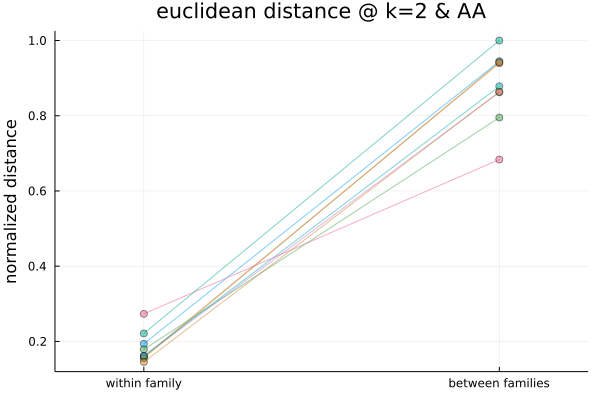

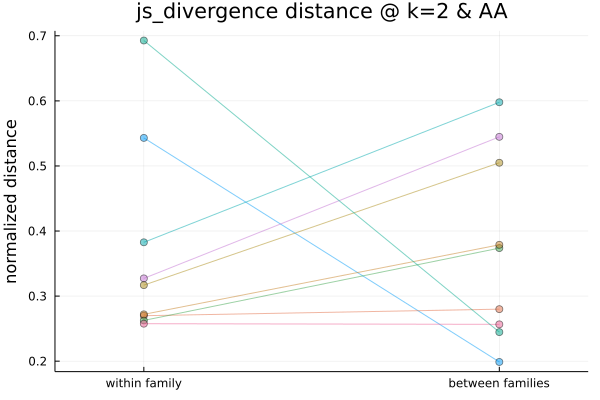

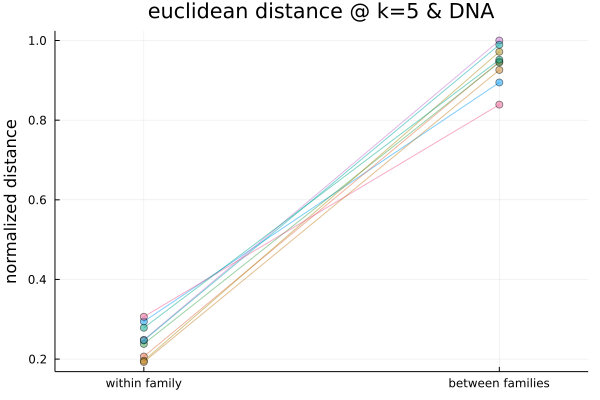

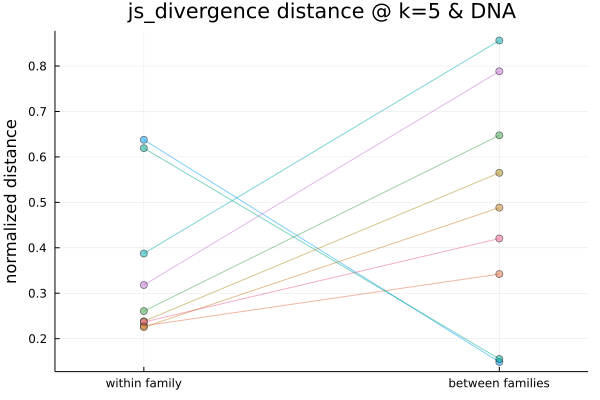

In [178]:
for (distance_matrix, distance_metric, grammar) in [
        (normalized_aa_euclidean_distance_matrix, "euclidean", "AA"),
        (normalized_aa_js_divergence_matrix, "js_divergence", "AA"),
        (normalized_dna_euclidean_distance_matrix, "euclidean", "DNA"),
        (normalized_dna_js_divergence_matrix, "js_divergence", "DNA"),
    ]
    
        within_vs_between_distances = []
        ProgressMeter.@showprogress for family in unique_families
            family_indices = findall(entity_metadata[!, "Family"] .== family)
            other_family_indices = setdiff(1:1:size(distance_matrix, 1), family_indices)
            for index in family_indices
                other_indices = filter(i -> i != index, family_indices)
                mean_within_family_distance = Statistics.mean(vec(distance_matrix[index, other_indices]))
                mean_between_family_distance = Statistics.mean(vec(distance_matrix[index, other_family_indices]))
                push!(within_vs_between_distances, mean_within_family_distance => mean_between_family_distance)
            end
        end
        within_vs_between_distances = filter(d -> !any(map(x1 -> isnan(x1), collect(d))), within_vs_between_distances)

        ys = collect.(within_vs_between_distances)

        xs = [[1, 2] for x in ys]
    
        if grammar == "AA"
            k = aa_k
        elseif grammar == "DNA"
            k = dna_k
        end

        p = StatsPlots.plot(
            xs,
            ys,
            xticks = ([1, 2], ["within family", "between families"]),
            legend = false,
            xlims = (0.75, 2.25),
            alpha = 0.5,
            title = "$(distance_metric) distance @ k=$k & $grammar",
            ylabel = "normalized distance",
            marker = :circle
        )
        StatsPlots.savefig(p, "$DIR/$(distance_metric)-distance-family-k$k-$(grammar).png")
        StatsPlots.savefig(p, "$DIR/$(distance_metric)-distance-family-k$k-$(grammar).svg")
        display(p)
end